In [217]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 1. Загрузка данных
Загрузим данные из CSV-файла и посмотрим на их структуру.

In [ ]:
url = "https://raw.githubusercontent.com/KseniiaKis/dz1/refs/heads/main/movies.csv"
data_raw = pd.read_csv(url)

data_raw.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


# 2.Предобработка данных

## Отбеливание данных

Заменим тип 'Object' на специальный, предназначенный для хранения категориальных значений

In [ ]:
data_raw['genre'] = data_raw['genre'].astype('category')
data_raw['company'] = data_raw['company'].astype('category')
data_raw['director'] = data_raw['director'].astype('category')
data_raw['rating'] = data_raw['rating'].astype('category')
data_raw['country'] = data_raw['country'].astype('category')
data_raw['star'] = data_raw['star'].astype('category')
data_raw['writer'] = data_raw['writer'].astype('category')
data_raw['name'] = data_raw['name'].astype('category')

Проверка на пропущенные значения

In [ ]:
data_raw.isnull().sum()

,0
name,0
rating,77
genre,0
year,0
released,2
score,3
votes,3
director,0
writer,3
star,1


Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам


In [ ]:
imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
imp_num.fit(data_raw[['budget', 'gross', 'runtime','votes', 'score']])
data_raw[['budget', 'gross', 'runtime','votes', 'score']] = imp_num.transform(data_raw[['budget', 'gross', 'runtime','votes', 'score']])

In [ ]:
data_raw.isnull().sum()

,0
name,0
rating,77
genre,0
year,0
released,2
score,0
votes,0
director,0
writer,3
star,1


Удалим строки в которыз есть пустые значения, соответствующие категориальным признакам


In [ ]:
data_raw = data_raw.dropna(subset=['rating', 'released', 'writer', 'star', 'country', 'company'])

Проверим не осталось ли пустых значений


In [ ]:
data_raw.isnull().sum()

,0
name,0
rating,0
genre,0
year,0
released,0
score,0
votes,0
director,0
writer,0
star,0


Избавимся от выбросов в "gross" и в "budget"

In [ ]:
rows_to_drop = data_raw[
    (data_raw['gross'] < data_raw['gross'].quantile(0.005)) | (data_raw['gross'] > data_raw['gross'].quantile(0.995)) |
    (data_raw['budget']  < data_raw['budget' ].quantile(0.005)) | (data_raw['budget']  > data_raw['budget' ].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)

Построим матрицу кореляции

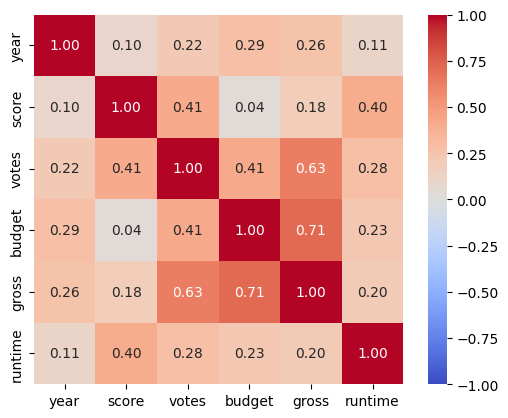

In [ ]:
corr_mat = data.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Мы видим, что 'score' мало зависит от 'year', 'budget' и 'gross'. Поэтому удалим их.

In [ ]:
data_raw = data_raw.drop([ 'year', 'budget', 'gross'], axis=1)

Название фильма и дата его выхода в прокат также дают слишком мало информации.

In [ ]:
data_raw = data_raw.drop(['name', 'released'], axis=1)

Удалим так же признак 'score', т.к. мы хотим, чтобы фильмы были разбиты на классы по этому признаку.

In [ ]:
# Округление оценок до целых чисел и ограничение диапазона
data_raw['score'] = np.round(data_raw['score']).astype(int)
data_raw['score'] = data_raw['score'].clip(lower=0, upper=10)

In [ ]:
true_labels = data_raw['score']
data_raw = data_raw.drop(['score'], axis=1)

## Подготовка данных

Кодирование категориальных признаков

In [ ]:
encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
encoder.fit(data_raw[['rating', 'genre', 'director', 'writer', 'country', 'company', 'star']])

OneHotEncoder(drop='if_binary', sparse_output=False)

In [ ]:
dummies = pd.DataFrame(encoder.transform(data_raw[['rating', 'genre', 'director', 'writer', 'country', 'company', 'star']]),
                       columns=encoder.get_feature_names_out(), index=data_raw.index)
dummies.head()

,rating_Approved,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-MA,rating_TV-PG,...,star_Zbigniew Zamachowski,star_Zelda Rubinstein,star_Zhi-zhong Huang,star_Ziyi Zhang,star_Zoe Margaret Colletti,star_Zoe Saldana,star_Zoey Deutch,star_Zooey Deschanel,star_Álex Angulo,star_Émilie Dequenne
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_raw = pd.concat((data_raw, dummies), axis=1).drop(['rating', 'writer', 'country', 'company','genre','director', 'star'], axis=1)
data_raw.head()

,votes,runtime,rating_Approved,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,rating_TV-14,...,star_Zbigniew Zamachowski,star_Zelda Rubinstein,star_Zhi-zhong Huang,star_Ziyi Zhang,star_Zoe Margaret Colletti,star_Zoe Saldana,star_Zoey Deutch,star_Zooey Deschanel,star_Álex Angulo,star_Émilie Dequenne
0,927000.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65000.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1200000.0,124.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,221000.0,88.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,108000.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Нормализация данных

In [ ]:
# Масштабирование количественных признаков
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data_raw)

In [ ]:
# Снижение размерности с помощью PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [ ]:
# Снижение размерности с помощью t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

#3. Кластеризация с использованием KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.

Best parameters for KMeans: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 300, 'kmeans__n_clusters': 3, 'kmeans__n_init': 10}
Best silhouette score for KMeans: nan


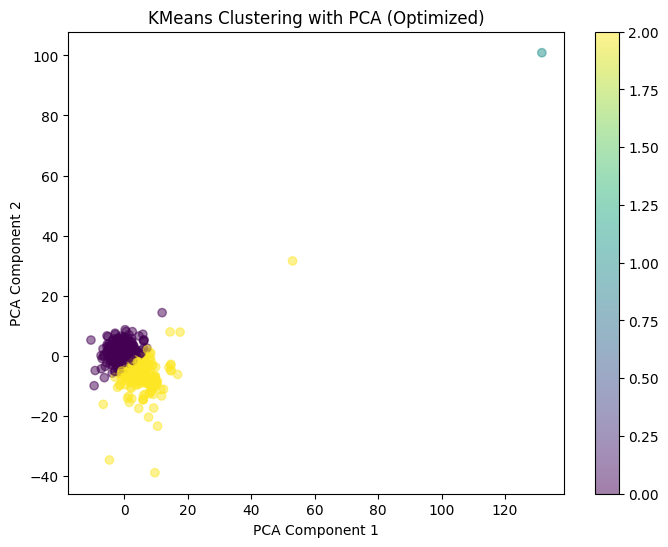

In [218]:
# Подбор параметров для KMeans с использованием GridSearchCV
kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(random_state=42))
])

param_grid = {
    'kmeans__n_clusters': [3, 5, 10, 15, 20],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [10, 20],
    'kmeans__max_iter': [300, 500]
}

# Создание собственного счётчика на основе silhouette_score
silhouette_scorer = make_scorer(silhouette_score)

grid_search_kmeans = GridSearchCV(kmeans_pipeline, param_grid, scoring=silhouette_scorer, cv=5)
grid_search_kmeans.fit(features_pca)

print("Best parameters for KMeans:", grid_search_kmeans.best_params_)
print("Best silhouette score for KMeans:", grid_search_kmeans.best_score_)

# Кластеризация с использованием лучших параметров KMeans
best_kmeans = grid_search_kmeans.best_estimator_
kmeans_labels = best_kmeans.predict(features_pca)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, alpha=0.5)
plt.title("KMeans Clustering with PCA (Optimized)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

#4. Кластеризация с использованием DBSCAN

Best parameters for DBSCAN: {'eps': 0.9, 'min_samples': 6}
Best silhouette score for DBSCAN: 0.8232403598664336


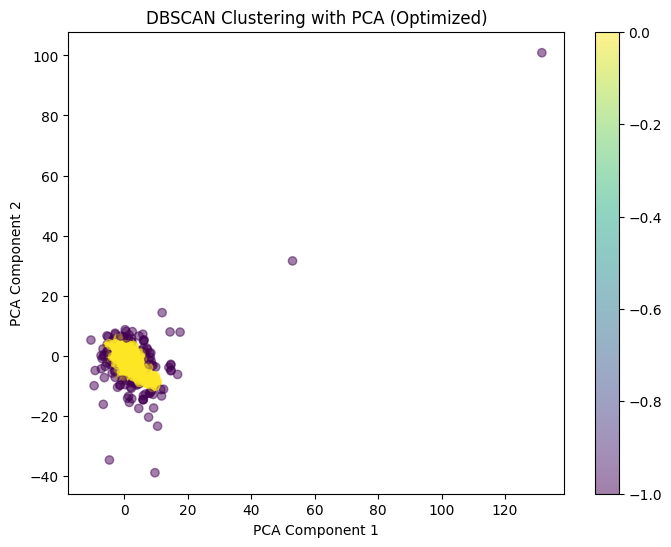

In [219]:
# Подбор параметров для DBSCAN
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(3, 10)

best_dbscan_score = -1
best_dbscan_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features_pca)

        if len(set(dbscan_labels)) > 1:  # Убедитесь, что есть более одного кластера
            score = silhouette_score(features_pca, dbscan_labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters for DBSCAN:", best_dbscan_params)
print("Best silhouette score for DBSCAN:", best_dbscan_score)

# Кластеризация с использованием лучших параметров DBSCAN
best_dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = best_dbscan.fit_predict(features_pca)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, alpha=0.5)
plt.title("DBSCAN Clustering with PCA (Optimized)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

#5. Иерархическая кластеризация

Best parameters for Hierarchical Clustering: {'n_clusters': 2}
Best silhouette score for Hierarchical Clustering: 0.9862371088392894


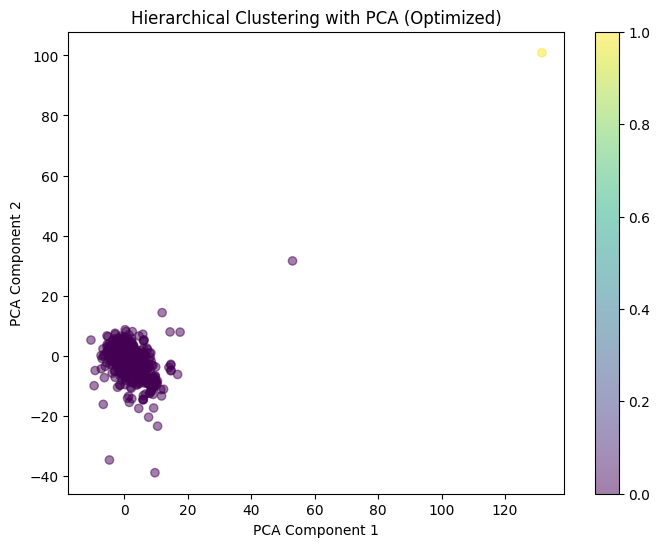

In [220]:
# Подбор параметров для иерархической кластеризации (количество кластеров)
n_clusters_list = range(2, 10)
best_hierarchical_score = -1
best_n_clusters = None

for n_clusters in n_clusters_list:
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(features_pca)

    score = silhouette_score(features_pca, hierarchical_labels)
    if score > best_hierarchical_score:
        best_hierarchical_score = score
        best_n_clusters = n_clusters

print("Best parameters for Hierarchical Clustering:", {'n_clusters': best_n_clusters})
print("Best silhouette score for Hierarchical Clustering:", best_hierarchical_score)

# Кластеризация с использованием лучших параметров иерархической кластеризации
best_hierarchical = AgglomerativeClustering(n_clusters=best_n_clusters)
hierarchical_labels = best_hierarchical.fit_predict(features_pca)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=hierarchical_labels, alpha=0.5)
plt.title("Hierarchical Clustering with PCA (Optimized)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.

Best parameters for KMeans (t-SNE): {'kmeans__init': 'k-means++', 'kmeans__max_iter': 300, 'kmeans__n_clusters': 3, 'kmeans__n_init': 10}
Best silhouette score for KMeans (t-SNE): nan


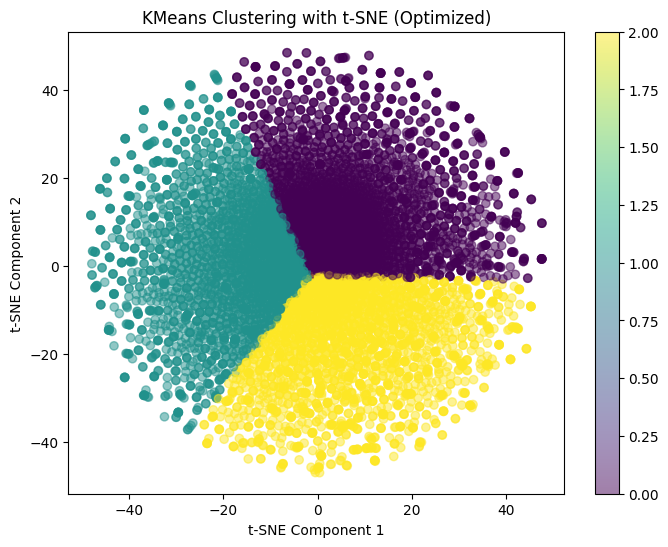

In [225]:
# Кластеризация с использованием KMeans (t-SNE)
kmeans_pipeline_tsne = Pipeline([
    ('kmeans', KMeans(random_state=42))
])

grid_search_kmeans_tsne = GridSearchCV(kmeans_pipeline_tsne, param_grid, scoring=silhouette_scorer, cv=5)
grid_search_kmeans_tsne.fit(features_tsne)

print("Best parameters for KMeans (t-SNE):", grid_search_kmeans_tsne.best_params_)
print("Best silhouette score for KMeans (t-SNE):", grid_search_kmeans_tsne.best_score_)

best_kmeans_tsne = grid_search_kmeans_tsne.best_estimator_
kmeans_labels_tsne = best_kmeans_tsne.predict(features_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels_tsne, alpha=0.5)
plt.title("KMeans Clustering with t-SNE (Optimized)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()
plt.show()

Best parameters for DBSCAN (t-SNE): {'eps': 0.7000000000000001, 'min_samples': 3}
Best silhouette score for DBSCAN (t-SNE): 0.015847895


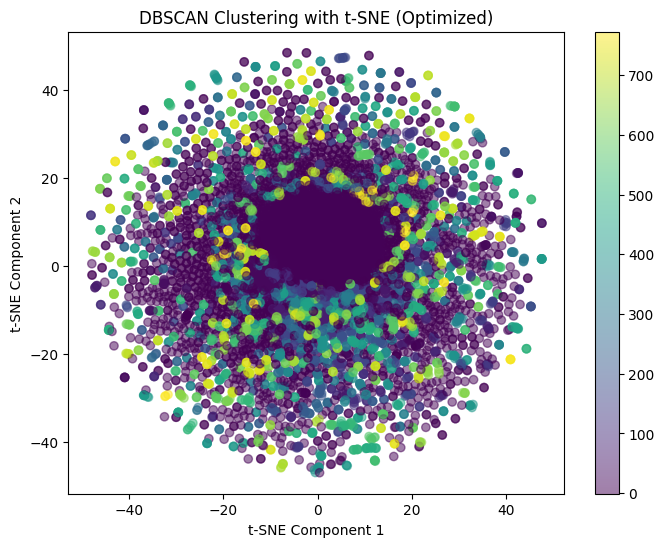

In [226]:
# Кластеризация с использованием DBSCAN (t-SNE)
best_dbscan_tsne_score = -1
best_dbscan_tsne_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_tsne = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels_tsne = dbscan_tsne.fit_predict(features_tsne)

        if len(set(dbscan_labels_tsne)) > 1:  # Убедитесь, что есть более одного кластера
            score = silhouette_score(features_tsne, dbscan_labels_tsne)
            if score > best_dbscan_tsne_score:
                best_dbscan_tsne_score = score
                best_dbscan_tsne_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters for DBSCAN (t-SNE):", best_dbscan_tsne_params)
print("Best silhouette score for DBSCAN (t-SNE):", best_dbscan_tsne_score)

best_dbscan_tsne = DBSCAN(eps=best_dbscan_tsne_params['eps'], min_samples=best_dbscan_tsne_params['min_samples'])
dbscan_labels_tsne = best_dbscan_tsne.fit_predict(features_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels_tsne, alpha=0.5)
plt.title("DBSCAN Clustering with t-SNE (Optimized)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()
plt.show()

Best parameters for Hierarchical Clustering (t-SNE): {'n_clusters': 2}
Best silhouette score for Hierarchical Clustering (t-SNE): 0.2934464


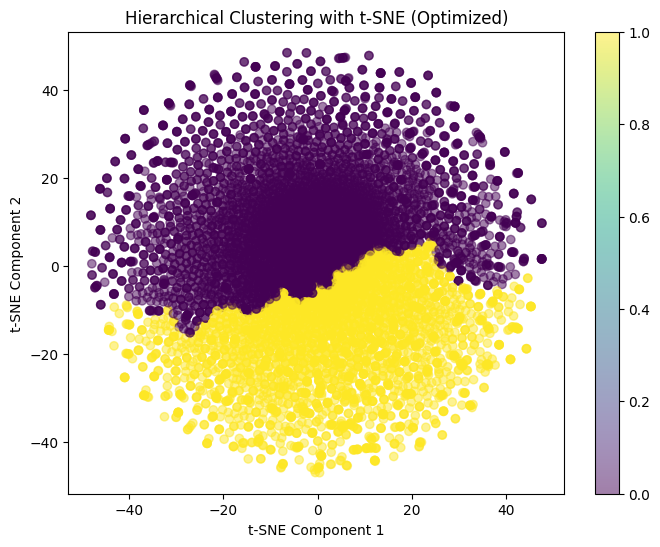

In [227]:
# Иерархическая кластеризация (t-SNE)
best_hierarchical_tsne_score = -1
best_n_clusters_tsne = None

for n_clusters in n_clusters_list:
    hierarchical_tsne = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels_tsne = hierarchical_tsne.fit_predict(features_tsne)

    score = silhouette_score(features_tsne, hierarchical_labels_tsne)
    if score > best_hierarchical_tsne_score:
        best_hierarchical_tsne_score = score
        best_n_clusters_tsne = n_clusters

print("Best parameters for Hierarchical Clustering (t-SNE):", {'n_clusters': best_n_clusters_tsne})
print("Best silhouette score for Hierarchical Clustering (t-SNE):", best_hierarchical_tsne_score)

best_hierarchical_tsne = AgglomerativeClustering(n_clusters=best_n_clusters_tsne)
hierarchical_labels_tsne = best_hierarchical_tsne.fit_predict(features_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=hierarchical_labels_tsne, alpha=0.5)
plt.title("Hierarchical Clustering with t-SNE (Optimized)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()
plt.show()

In [221]:
# Оценка качества кластеризации на PCA
print("KMeans ARI (PCA):", adjusted_rand_score(true_labels, kmeans_labels))
print("KMeans Silhouette Score (PCA):", silhouette_score(features_pca, kmeans_labels))

print("DBSCAN ARI (PCA):", adjusted_rand_score(true_labels, dbscan_labels))
print("DBSCAN Silhouette Score (PCA):", silhouette_score(features_pca, dbscan_labels))

print("Hierarchical ARI (PCA):", adjusted_rand_score(true_labels, hierarchical_labels))
print("Hierarchical Silhouette Score (PCA):", silhouette_score(features_pca, hierarchical_labels))

KMeans ARI (PCA): 0.0193269408312423
KMeans Silhouette Score (PCA): 0.7695810855481643
DBSCAN ARI (PCA): 0.005726530694451779
DBSCAN Silhouette Score (PCA): 0.8232403598664336
Hierarchical ARI (PCA): -7.225369840667914e-05
Hierarchical Silhouette Score (PCA): 0.9862371088392894


In [228]:
# Оценка качества кластеризации на t-SNE
print("KMeans ARI (t-SNE):", adjusted_rand_score(true_labels, kmeans_labels_tsne))
print("KMeans Silhouette Score (t-SNE):", silhouette_score(features_tsne, kmeans_labels_tsne))

print("DBSCAN ARI (t-SNE):", adjusted_rand_score(true_labels, dbscan_labels_tsne))
print("DBSCAN Silhouette Score (t-SNE):", silhouette_score(features_tsne, dbscan_labels_tsne))

print("Hierarchical ARI (t-SNE):", adjusted_rand_score(true_labels, hierarchical_labels_tsne))
print("Hierarchical Silhouette Score (t-SNE):", silhouette_score(features_tsne, hierarchical_labels_tsne))

KMeans ARI (t-SNE): 0.0017880112015548149
KMeans Silhouette Score (t-SNE): 0.31480786
DBSCAN ARI (t-SNE): -0.0012774526121236511
DBSCAN Silhouette Score (t-SNE): 0.015847895
Hierarchical ARI (t-SNE): -0.0045442310434761594
Hierarchical Silhouette Score (t-SNE): 0.2934464


# Выводы:

1. PCA vs t-SNE:

   • На основе PCA все алгоритмы показывают более высокие значения Silhouette Score по сравнению с t-SNE, что указывает на то, что кластеры более четко отделены в пространстве PCA.

   • t-SNE, несмотря на то, что он часто используется для визуализации высокоразмерных данных, в данном случае не смог обеспечить хорошую кластеризацию, как это видно из низких значений Silhouette Score и отрицательных значений ARI.

2. KMeans:

   • KMeans показывает хорошие результаты по Silhouette Score в PCA, но его ARI указывает на то, что метки кластеров не согласуются с истинными метками классов.

   • В t-SNE KMeans имеет низкие показатели и плохую разделимость кластеров.

3. DBSCAN:

   • DBSCAN также показывает высокие значения Silhouette Score в PCA, но его ARI остается низким.

   • В t-SNE результаты DBSCAN значительно ухудшаются.

4. Hierarchical Clustering:

   • Hierarchical clustering имеет очень низкие и отрицательные значения ARI как в PCA, так и в t-SNE, что указывает на плохую согласованность с истинными метками классов.

   • Однако Silhouette Score в PCA очень высок, что может указывать на то, что алгоритм создает хорошо отделенные кластеры, но они не соответствуют истинным меткам.